# Data Preprocessing Pipeline for VAD Distillation

This notebook implements the complete data preprocessing pipeline:

1. Scan and reorganize OPUS audio files from `H:\wenet_data`
2. Decode OPUS files to PCM waveforms
3. Extract 80-mel filterbank features
4. Generate metadata and segmentation files
5. Create 2-second chunks with 0.5-second overlap
6. Prepare dataset for model training

**Input**: `H:\wenet_data` (contains OPUS files)
**Output**: `H:\wenet_data_processed` (organized structure)


In [24]:
from __future__ import annotations

import json
import random
import shutil
import subprocess
import warnings
from pathlib import Path
from typing import Any

import numpy as np
import torch
import torchaudio
from tqdm import tqdm

from vad_distill.teacher.frame_level_teacher import FrameLevelTeacher

# Suppress tqdm auto-detection warning
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

# Configuration
INPUT_DIR = Path(r"H:\wenet_data")
OUTPUT_DIR = Path(r"H:\wenet_data_processed")

SAMPLE_RATE = 16000
N_MELS = 80
FRAME_LEN = 0.025  # 25 ms
FRAME_HOP = 0.01  # 10 ms

# Chunk configuration (matching training expectations)
CHUNK_SIZE_FRAMES = 100  # 1 second at 10ms per frame
CHUNK_STRIDE_FRAMES = 50  # 0.5 second overlap
CHUNK_DURATION = CHUNK_SIZE_FRAMES * FRAME_HOP  # 1.0 seconds
CHUNK_OVERLAP = (CHUNK_SIZE_FRAMES - CHUNK_STRIDE_FRAMES) * FRAME_HOP  # 0.5 seconds

# Data selection
RANDOM_SEED = 42
MAX_FILES = 1000  # Maximum number of files to process

# Training output directory (use processed data directory)
TRAINING_CHUNKS_DIR = OUTPUT_DIR / "chunks" / "audio"
TRAINING_TEACHER_PROBS_DIR = OUTPUT_DIR / "chunks" / "labels"

# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Configuration:")
print(f"  Sample rate: {SAMPLE_RATE} Hz")
print(f"  Mel bins: {N_MELS}")
print(f"  Chunk duration: {CHUNK_DURATION}s ({CHUNK_SIZE_FRAMES} frames)")
print(f"  Chunk overlap: {CHUNK_OVERLAP}s")
print(f"  Chunk stride: {CHUNK_STRIDE_FRAMES * FRAME_HOP}s ({CHUNK_STRIDE_FRAMES} frames)")
print(f"  Max files to process: {MAX_FILES}")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Training chunks dir: {TRAINING_CHUNKS_DIR}")
print(f"  Training teacher probs dir: {TRAINING_TEACHER_PROBS_DIR}")


Configuration:
  Sample rate: 16000 Hz
  Mel bins: 80
  Chunk duration: 1.0s (100 frames)
  Chunk overlap: 0.5s
  Chunk stride: 0.5s (50 frames)
  Max files to process: 1000
  Random seed: 42
  Training chunks dir: H:\wenet_data_processed\chunks\audio
  Training teacher probs dir: H:\wenet_data_processed\chunks\labels


## (2) Directory Initialization & Cleanup

Create the output directory structure and clean existing files if needed.


In [25]:
# Define directory structure
DIRS = {
    "raw_opus": OUTPUT_DIR / "raw" / "opus",
    "raw_wav": OUTPUT_DIR / "raw" / "wav",
    "features_fbank": OUTPUT_DIR / "features" / "fbank",
    "metadata": OUTPUT_DIR / "metadata",
    "chunks_audio": OUTPUT_DIR / "chunks" / "audio",
    "chunks_labels": OUTPUT_DIR / "chunks" / "labels",
}

# Create training directories
TRAINING_CHUNKS_DIR.mkdir(parents=True, exist_ok=True)
TRAINING_TEACHER_PROBS_DIR.mkdir(parents=True, exist_ok=True)

# Clean and create directories
if OUTPUT_DIR.exists():
    print(f"Cleaning existing output directory: {OUTPUT_DIR}")
    shutil.rmtree(OUTPUT_DIR)

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
for dir_path in DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"Created: {dir_path}")

print(f"\nOutput directory structure initialized at: {OUTPUT_DIR}")


Cleaning existing output directory: H:\wenet_data_processed
Created: H:\wenet_data_processed\raw\opus
Created: H:\wenet_data_processed\raw\wav
Created: H:\wenet_data_processed\features\fbank
Created: H:\wenet_data_processed\metadata
Created: H:\wenet_data_processed\chunks\audio
Created: H:\wenet_data_processed\chunks\labels

Output directory structure initialized at: H:\wenet_data_processed


## (3) File Scanning & OPUS Copy

Scan the input directory for all OPUS files and copy them to the organized structure.


In [26]:
def scan_opus_files(root_dir: Path) -> list[Path]:
    """Scan recursively for all OPUS files."""
    opus_files = []
    for ext in [".opus", ".OPUS"]:
        opus_files.extend(root_dir.rglob(f"*{ext}"))
    return sorted(opus_files)

# Scan input directory
print(f"Scanning for OPUS files in: {INPUT_DIR}")
if not INPUT_DIR.exists():
    raise FileNotFoundError(f"Input directory does not exist: {INPUT_DIR}")

opus_files = scan_opus_files(INPUT_DIR)
print(f"Found {len(opus_files)} OPUS files")

# Randomly select up to MAX_FILES
if len(opus_files) > MAX_FILES:
    print(f"Randomly selecting {MAX_FILES} files from {len(opus_files)} total files...")
    selected_files = random.sample(opus_files, MAX_FILES)
    print(f"Selected {len(selected_files)} files for processing")
else:
    selected_files = opus_files
    print(f"Using all {len(selected_files)} files (less than {MAX_FILES})")

# Copy OPUS files to organized structure
opus_mapping = {}
for opus_file in tqdm(selected_files, desc="Copying OPUS files"):
    # Create unique identifier from relative path
    rel_path = opus_file.relative_to(INPUT_DIR)
    file_id = str(rel_path).replace("\\", "_").replace("/", "_").replace(".opus", "").replace(".OPUS", "")
    
    # Copy to organized location
    dest_path = DIRS["raw_opus"] / f"{file_id}.opus"
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(opus_file, dest_path)
    opus_mapping[file_id] = {
        "original_path": str(opus_file),
        "opus_path": str(dest_path),
    }

print(f"\nCopied {len(opus_mapping)} OPUS files to {DIRS['raw_opus']}")
print(f"Sample file IDs: {list(opus_mapping.keys())[:5]}")


Scanning for OPUS files in: H:\wenet_data
Found 167006 OPUS files
Randomly selecting 1000 files from 167006 total files...
Selected 1000 files for processing


Copying OPUS files: 100%|██████████| 1000/1000 [00:07<00:00, 128.63it/s]


Copied 997 OPUS files to H:\wenet_data_processed\raw\opus
Sample file IDs: ['audio_test_meeting_third_party_B00002_TEST_MEETING_T0000000767', 'audio_dev_third_party_B00012_DEV_T0000003278', 'audio_train_podcast_B00053_X0000013729_279194376', 'audio_train_podcast_B00038_X0000009779_344990009', 'audio_train_podcast_B00027_X0000006937_289373091']


## (4) OPUS Decoding Utilities

Implement reliable OPUS decoding using ffmpeg subprocess (fallback to torchaudio if available).


In [27]:
def check_ffmpeg() -> bool:
    """Check if ffmpeg is available."""
    try:
        subprocess.run(
            ["ffmpeg", "-version"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            check=True,
        )
        return True
    except (subprocess.CalledProcessError, FileNotFoundError):
        return False


def load_opus_ffmpeg(opus_path: Path, target_sr: int = SAMPLE_RATE) -> tuple[np.ndarray, float]:
    """
    Decode OPUS file using ffmpeg subprocess.
    
    Returns:
        waveform: float32 numpy array, mono
        duration: duration in seconds
    """
    cmd = [
        "ffmpeg",
        "-i", str(opus_path),
        "-f", "f32le",
        "-acodec", "pcm_f32le",
        "-ac", "1",
        "-ar", str(target_sr),
        "-",
    ]
    
    try:
        result = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            check=True,
        )
        waveform = np.frombuffer(result.stdout, dtype=np.float32)
        
        # Get duration from stderr
        duration_str = None
        for line in result.stderr.decode("utf-8", errors="ignore").split("\n"):
            if "Duration:" in line:
                parts = line.split("Duration:")[1].split(",")[0].strip()
                h, m, s = map(float, parts.split(":"))
                duration = h * 3600 + m * 60 + s
                break
        else:
            duration = len(waveform) / target_sr
        
        return waveform, duration
    except subprocess.CalledProcessError as e:
        raise RuntimeError(f"ffmpeg failed for {opus_path}: {e.stderr.decode('utf-8', errors='ignore')}")


def load_opus(opus_path: Path, target_sr: int = SAMPLE_RATE) -> tuple[np.ndarray, float]:
    """
    Load OPUS file, trying torchaudio first, then ffmpeg.
    
    Returns:
        waveform: float32 numpy array, mono, at target_sr
        duration: duration in seconds
    """
    opus_path = Path(opus_path)
    
    # Try torchaudio first
    try:
        waveform, sr = torchaudio.load(str(opus_path))
        waveform = waveform.numpy()
        if waveform.ndim > 1:
            waveform = np.mean(waveform, axis=0)
        waveform = waveform.astype(np.float32)
        
        if sr != target_sr:
            waveform_tensor = torch.from_numpy(waveform).unsqueeze(0)
            resampled = torchaudio.functional.resample(waveform_tensor, sr, target_sr)
            waveform = resampled.squeeze(0).numpy().astype(np.float32)
        
        duration = len(waveform) / target_sr
        return waveform, duration
    except Exception:
        pass
    
    # Fallback to ffmpeg
    if check_ffmpeg():
        return load_opus_ffmpeg(opus_path, target_sr)
    else:
        raise RuntimeError(
            f"Cannot decode OPUS file {opus_path}. "
            "torchaudio failed and ffmpeg is not available."
        )


# Test OPUS loading
if opus_mapping:
    test_file_id = list(opus_mapping.keys())[0]
    test_path = Path(opus_mapping[test_file_id]["opus_path"])
    print(f"Testing OPUS loading with: {test_path.name}")
    try:
        test_wav, test_dur = load_opus(test_path)
        print(f"  Success: loaded {len(test_wav)} samples, duration {test_dur:.2f}s")
        print(f"  Sample rate: {SAMPLE_RATE} Hz, shape: {test_wav.shape}, dtype: {test_wav.dtype}")
    except Exception as e:
        print(f"  Error: {e}")
        print("  Please ensure ffmpeg is installed or torchaudio can decode OPUS files")
        raise
else:
    print("No OPUS files found to test")


Testing OPUS loading with: audio_test_meeting_third_party_B00002_TEST_MEETING_T0000000767.opus
  Success: loaded 96229 samples, duration 6.02s
  Sample rate: 16000 Hz, shape: (96229,), dtype: float32


## (5) Metadata Builder

Generate file-level and segment-level metadata, plus statistics.


In [28]:
def extract_fbank(waveform: np.ndarray, sample_rate: int = SAMPLE_RATE, n_mels: int = N_MELS) -> np.ndarray:
    """
    Extract log-mel filterbank features using torchaudio.
    
    Args:
        waveform: 1-D float32 numpy array
        sample_rate: Sampling rate in Hz
        n_mels: Number of mel bins
    
    Returns:
        fbank: (T, n_mels) float32 array
    """
    if waveform.ndim != 1:
        raise ValueError(f"Expected mono waveform, got shape {waveform.shape}")
    
    waveform_tensor = torch.from_numpy(waveform.copy()).unsqueeze(0)

    frame_length_ms = FRAME_LEN * 1000.0
    frame_shift_ms = FRAME_HOP * 1000.0
    
    fbank = torchaudio.compliance.kaldi.fbank(
        waveform_tensor,
        sample_frequency=sample_rate,
        num_mel_bins=n_mels,
        frame_length=frame_length_ms,
        frame_shift=frame_shift_ms,
        dither=0.0,
        energy_floor=1.0,
    )
    return fbank.numpy().astype(np.float32)


# Process all files and build metadata
metadata_records = []
segments_records = []
durations = []
corrupt_files = []

print("Processing OPUS files and building metadata...")

for file_id, file_info in tqdm(opus_mapping.items(), desc="Processing files"):
    opus_path = Path(file_info["opus_path"])
    
    try:
        # Load audio
        waveform, duration = load_opus(opus_path)
        
        if len(waveform) == 0 or duration < 0.1:
            print(f"  Skipping {file_id}: too short or empty")
            corrupt_files.append(file_id)
            continue
        
        # Extract features
        fbank = extract_fbank(waveform)
        n_frames = fbank.shape[0]
        
        # Save features
        feature_path = DIRS["features_fbank"] / f"{file_id}.npy"
        np.save(feature_path, fbank)
        
        # File-level metadata
        metadata_records.append({
            "file_id": file_id,
            "opus_path": str(opus_path),
            "duration": float(duration),
            "sample_rate": SAMPLE_RATE,
            "n_samples": len(waveform),
            "n_frames": n_frames,
            "feature_path": str(feature_path),
        })
        
        # Segment-level metadata (continuous segmentation, default 10s chunks)
        segment_duration = 10.0
        n_segments = int(np.ceil(duration / segment_duration))
        
        for seg_idx in range(n_segments):
            seg_start = seg_idx * segment_duration
            seg_end = min(seg_start + segment_duration, duration)
            seg_frames_start = int(seg_start / FRAME_HOP)
            seg_frames_end = int(seg_end / FRAME_HOP)
            
            segments_records.append({
                "file_id": file_id,
                "segment_id": f"{file_id}_seg{seg_idx:03d}",
                "start_time": float(seg_start),
                "end_time": float(seg_end),
                "duration": float(seg_end - seg_start),
                "start_frame": seg_frames_start,

                "end_frame": seg_frames_end,
            })
        
        durations.append(duration)
        
    except Exception as e:
        print(f"  Error processing {file_id}: {e}")
        corrupt_files.append(file_id)
        continue

print(f"\nProcessed {len(metadata_records)} files successfully")
print(f"Skipped {len(corrupt_files)} corrupt/empty files")
if corrupt_files:
    print(f"Corrupt files: {corrupt_files[:10]}...")


Processing OPUS files and building metadata...


Processing files: 100%|██████████| 997/997 [19:45<00:00,  1.19s/it]  


Processed 997 files successfully
Skipped 0 corrupt/empty files


In [29]:
# Save metadata files
metadata_path = DIRS["metadata"] / "metadata.jsonl"
with open(metadata_path, "w", encoding="utf-8") as f:
    for record in metadata_records:
        f.write(json.dumps(record, ensure_ascii=False) + "\n")
print(f"Saved {len(metadata_records)} metadata records to {metadata_path}")

segments_path = DIRS["metadata"] / "segments.jsonl"
with open(segments_path, "w", encoding="utf-8") as f:
    for record in segments_records:
        f.write(json.dumps(record, ensure_ascii=False) + "\n")
print(f"Saved {len(segments_records)} segment records to {segments_path}")

# Generate statistics
if durations:
    stats = {
        "total_files": len(metadata_records),
        "total_segments": len(segments_records),
        "total_duration_hours": sum(durations) / 3600.0,
        "duration_stats": {
            "min": float(np.min(durations)),
            "max": float(np.max(durations)),
            "mean": float(np.mean(durations)),
            "median": float(np.median(durations)),
            "std": float(np.std(durations)),
        },
        "duration_histogram": {
            "bins": [0, 1, 5, 10, 30, 60, 300, float("inf")],
            "counts": [
                sum(1 for d in durations if b0 <= d < b1)
                for b0, b1 in zip([0, 1, 5, 10, 30, 60, 300], [1, 5, 10, 30, 60, 300, float("inf")])
            ],
        },
    }
    
    stats_path = DIRS["metadata"] / "stats.json"
    with open(stats_path, "w", encoding="utf-8") as f:
        json.dump(stats, f, indent=2, ensure_ascii=False)
    print(f"Saved statistics to {stats_path}")
    print(f"\nStatistics:")
    print(f"  Total files: {stats['total_files']}")
    print(f"  Total duration: {stats['total_duration_hours']:.2f} hours")
    print(f"  Duration range: {stats['duration_stats']['min']:.2f}s - {stats['duration_stats']['max']:.2f}s")
    print(f"  Mean duration: {stats['duration_stats']['mean']:.2f}s")
else:
    print("No valid files to generate statistics")


Saved 997 metadata records to H:\wenet_data_processed\metadata\metadata.jsonl
Saved 97548 segment records to H:\wenet_data_processed\metadata\segments.jsonl
Saved statistics to H:\wenet_data_processed\metadata\stats.json

Statistics:
  Total files: 997
  Total duration: 269.51 hours
  Duration range: 1.91s - 10105.61s
  Mean duration: 973.14s


## (6) Fbank Extraction

Feature extraction is already performed in the metadata building step. This section verifies the features.


In [30]:
def save_feature(file_id: str, features: np.ndarray) -> Path:
    """Save fbank features to disk."""
    feature_path = DIRS["features_fbank"] / f"{file_id}.npy"
    np.save(feature_path, features)
    return feature_path


# Verify feature extraction
if metadata_records:
    sample_record = metadata_records[0]
    sample_feature_path = Path(sample_record["feature_path"])
    
    if sample_feature_path.exists():
        sample_fbank = np.load(sample_feature_path)
        print(f"Sample feature verification:")
        print(f"  File ID: {sample_record['file_id']}")
        print(f"  Shape: {sample_fbank.shape} (expected: (T, {N_MELS}))")
        print(f"  Dtype: {sample_fbank.dtype}")
        print(f"  Min: {sample_fbank.min():.3f}, Max: {sample_fbank.max():.3f}")
        print(f"  Mean: {sample_fbank.mean():.3f}, Std: {sample_fbank.std():.3f}")
        
        # Count total feature files
        feature_files = list(DIRS["features_fbank"].glob("*.npy"))
        print(f"\nTotal feature files saved: {len(feature_files)}")
    else:
        print(f"Warning: Feature file not found: {sample_feature_path}")
else:
    print("No metadata records to verify")


Sample feature verification:
  File ID: audio_test_meeting_third_party_B00002_TEST_MEETING_T0000000767
  Shape: (599, 80) (expected: (T, 80))
  Dtype: float32
  Min: -15.942, Max: -0.849
  Mean: -7.543, Std: 1.978

Total feature files saved: 997


## (7) Chunking & Label Generation

Generate 2-second chunks with 0.5-second overlap. Create audio chunks and placeholder labels.


In [31]:
def create_chunks_from_fbank(
    file_id: str,
    fbank: np.ndarray,
    teacher_probs: np.ndarray,
    start_chunk_id: int = 0,
    chunk_size_frames: int = CHUNK_SIZE_FRAMES,
    stride_frames: int = CHUNK_STRIDE_FRAMES,
) -> tuple[int, list[dict[str, Any]]]:
    """
    Create overlapping chunks from fbank features with teacher labels in training format.
    
    Args:
        file_id: Unique file identifier
        fbank: (T, n_mels) feature array
        teacher_probs: (T,) teacher probabilities array (frame-level)
        start_chunk_id: Starting chunk ID for global numbering
        chunk_size_frames: Number of frames per chunk
        stride_frames: Stride between chunk starts
    
    Returns:
        (next_chunk_id, list of chunk metadata dictionaries)
    """
    if fbank.ndim != 2 or fbank.shape[1] != N_MELS:
        raise ValueError(f"Expected (T, {N_MELS}) fbank, got {fbank.shape}")
    if teacher_probs.ndim != 1:
        raise ValueError(f"Expected 1-D teacher_probs, got {teacher_probs.shape}")
    if fbank.shape[0] != teacher_probs.shape[0]:
        raise ValueError(f"fbank frames {fbank.shape[0]} != teacher_probs frames {teacher_probs.shape[0]}")
    
    chunks = []
    total_frames = fbank.shape[0]
    
    if total_frames < chunk_size_frames:
        return start_chunk_id, chunks
    
    chunk_id = start_chunk_id
    for start_frame in range(0, total_frames - chunk_size_frames + 1, stride_frames):
        end_frame = start_frame + chunk_size_frames
        chunk_features = fbank[start_frame:end_frame]
        chunk_teacher_probs = teacher_probs[start_frame:end_frame]
        
        # Generate hard labels from teacher probabilities
        hard_labels = (chunk_teacher_probs >= 0.5).astype(np.float32)
        
        # Save in training format: dictionary with features, teacher_probs, and hard_labels
        chunk_filename = f"chunk_{chunk_id:06d}.npy"
        chunk_path = TRAINING_CHUNKS_DIR / chunk_filename
        
        chunk_data = {
            "uid": file_id,
            "chunk_id": chunk_id,
            "features": chunk_features.astype(np.float32),
            "teacher_probs": chunk_teacher_probs.astype(np.float32),
            "hard_labels": hard_labels.astype(np.float32),
            "frame_start": int(start_frame),
            "frame_end": int(end_frame),
        }
        np.save(chunk_path, chunk_data, allow_pickle=True)
        
        chunks.append({
            "chunk_id": chunk_id,
            "chunk_filename": chunk_filename,
            "file_id": file_id,
            "start_frame": int(start_frame),
            "end_frame": int(end_frame),
            "start_time": float(start_frame * FRAME_HOP),
            "end_time": float(end_frame * FRAME_HOP),
        })
        chunk_id += 1
    
    return chunk_id, chunks


# Initialize teacher model for labeling
print("Initializing Silero teacher model...")
teacher = FrameLevelTeacher(device="auto")
print("Teacher model ready")

# Generate chunks for all files with teacher labels
all_chunks = []
current_chunk_id = 0
print("Generating chunks from fbank features with teacher labels...")

for record in tqdm(metadata_records, desc="Chunking files"):
    file_id = record["file_id"]
    feature_path = Path(record["feature_path"])
    opus_path = Path(record["opus_path"])
    
    if not feature_path.exists():
        continue
    
    # Load fbank features
    fbank = np.load(feature_path)
    
    # Generate teacher probabilities from original audio
    try:
        # Load OPUS audio and get teacher probabilities
        wav, _ = load_opus(opus_path)
        teacher_probs, _ = teacher.infer(wav, sr=SAMPLE_RATE)
        # Ensure teacher_probs length matches fbank frames
        n_fbank_frames = fbank.shape[0]
        n_teacher_frames = len(teacher_probs)
        
        if n_teacher_frames > n_fbank_frames:
            # Truncate teacher_probs to match fbank
            teacher_probs = teacher_probs[:n_fbank_frames]
        elif n_teacher_frames < n_fbank_frames:
            # Pad teacher_probs with zeros if shorter
            padding = np.zeros(n_fbank_frames - n_teacher_frames, dtype=np.float32)
            teacher_probs = np.concatenate([teacher_probs, padding])
        
    except Exception as e:
        print(f"  Warning: Failed to generate teacher labels for {file_id}: {e}")
        print(f"  Using zero labels as fallback")
        # Fallback to zeros if teacher inference fails
        teacher_probs = np.zeros(fbank.shape[0], dtype=np.float32)
    
    # Create chunks with teacher labels
    next_chunk_id, chunks = create_chunks_from_fbank(
        file_id, fbank, teacher_probs, start_chunk_id=current_chunk_id
    )
    all_chunks.extend(chunks)
    current_chunk_id = next_chunk_id

print(f"\nGenerated {len(all_chunks)} chunks")
print(f"  Chunks saved to: {TRAINING_CHUNKS_DIR}")

# Save chunk metadata
chunk_metadata_path = DIRS["metadata"] / "chunks.jsonl"
with open(chunk_metadata_path, "w", encoding="utf-8") as f:
    for chunk in all_chunks:
        f.write(json.dumps(chunk, ensure_ascii=False) + "\n")
print(f"  Chunk metadata saved to: {chunk_metadata_path}")

# Verify chunk structure
if all_chunks:
    sample_chunk = all_chunks[0]
    sample_chunk_path = TRAINING_CHUNKS_DIR / sample_chunk["chunk_filename"]
    sample_data = np.load(sample_chunk_path, allow_pickle=True).item()
    print(f"\nSample chunk verification:")
    print(f"  Chunk ID: {sample_chunk['chunk_id']}")
    print(f"  Filename: {sample_chunk['chunk_filename']}")
    print(f"  Features shape: {sample_data['features'].shape} (expected: ({CHUNK_SIZE_FRAMES}, {N_MELS}))")
    print(f"  Teacher probs shape: {sample_data['teacher_probs'].shape} (expected: ({CHUNK_SIZE_FRAMES},))")
    print(f"  Hard labels shape: {sample_data['hard_labels'].shape} (expected: ({CHUNK_SIZE_FRAMES},))")
    print(f"  Teacher probs range: [{sample_data['teacher_probs'].min():.3f}, {sample_data['teacher_probs'].max():.3f}]")
    print(f"  Duration: {sample_chunk['end_time'] - sample_chunk['start_time']:.2f}s (expected: {CHUNK_DURATION}s)")
    
    # Verify file naming
    chunk_files = list(TRAINING_CHUNKS_DIR.glob("chunk_*.npy"))
    print(f"\n  Total chunk files in training directory: {len(chunk_files)}")
    if chunk_files:
        print(f"  Sample filenames: {[f.name for f in chunk_files[:3]]}")


Initializing Silero teacher model...
Teacher model ready
Generating chunks from fbank features with teacher labels...


Chunking files: 100%|██████████| 997/997 [7:01:47<00:00, 25.38s/it]   



Generated 1938918 chunks
  Chunks saved to: H:\wenet_data_processed\chunks\audio
  Chunk metadata saved to: H:\wenet_data_processed\metadata\chunks.jsonl

Sample chunk verification:
  Chunk ID: 0
  Filename: chunk_000000.npy
  Features shape: (100, 80) (expected: (100, 80))
  Teacher probs shape: (100,) (expected: (100,))
  Hard labels shape: (100,) (expected: (100,))
  Teacher probs range: [0.501, 0.726]
  Duration: 1.00s (expected: 1.0s)

  Total chunk files in training directory: 1938918
  Sample filenames: ['chunk_000000.npy', 'chunk_000001.npy', 'chunk_000002.npy']


## (8) Final Verification & Summary

Verify the complete pipeline output and generate a summary report.


In [32]:
# Final verification
print("=" * 60)
print("FINAL VERIFICATION & SUMMARY")
print("=" * 60)

# Check directory structure
print("\n1. Directory Structure:")
for name, dir_path in DIRS.items():
    exists = dir_path.exists()
    file_count = len(list(dir_path.rglob("*"))) if exists else 0
    print(f"  {name:20s}: {str(dir_path):50s} [{'OK' if exists else 'MISSING'}] ({file_count} items)")

# Check metadata files
print("\n2. Metadata Files:")
metadata_files = {
    "metadata.jsonl": DIRS["metadata"] / "metadata.jsonl",
    "segments.jsonl": DIRS["metadata"] / "segments.jsonl",
    "stats.json": DIRS["metadata"] / "stats.json",
    "chunks.jsonl": DIRS["metadata"] / "chunks.jsonl",
}

for name, path in metadata_files.items():
    if path.exists():
        with open(path, "r", encoding="utf-8") as f:
            if name.endswith(".jsonl"):
                count = sum(1 for _ in f)
            else:
                data = json.load(f)
                count = len(data) if isinstance(data, list) else "N/A"
        print(f"  {name:20s}: {count} records")
    else:
        print(f"  {name:20s}: MISSING")

# Check feature files
print("\n3. Feature Files:")
feature_files = list(DIRS["features_fbank"].glob("*.npy"))
print(f"  Total fbank files: {len(feature_files)}")
if feature_files:
    sample_feat = np.load(feature_files[0])
    print(f"  Sample shape: {sample_feat.shape}, dtype: {sample_feat.dtype}")

# Check chunk files in training directory
print("\n4. Training Chunk Files:")
training_chunks = list(TRAINING_CHUNKS_DIR.glob("chunk_*.npy"))
print(f"  Training chunks: {len(training_chunks)}")
if training_chunks:
    sample_chunk_path = training_chunks[0]
    sample_data = np.load(sample_chunk_path, allow_pickle=True).item()
    print(f"  Sample chunk file: {sample_chunk_path.name}")
    print(f"  Features shape: {sample_data['features'].shape}")
    print(f"  Teacher probs shape: {sample_data.get('teacher_probs', 'MISSING')}")
    print(f"  Hard labels shape: {sample_data['hard_labels'].shape}")
    print(f"  Contains keys: {list(sample_data.keys())}")
    if 'teacher_probs' in sample_data:
        print(f"  Teacher probs range: [{sample_data['teacher_probs'].min():.3f}, {sample_data['teacher_probs'].max():.3f}]")

# Summary statistics
print("\n5. Summary Statistics:")
if durations:
    total_duration = sum(durations)
    print(f"  Total audio duration: {total_duration / 3600:.2f} hours")
    print(f"  Number of files: {len(metadata_records)}")
    print(f"  Number of segments: {len(segments_records)}")
    print(f"  Number of chunks: {len(all_chunks)}")
    print(f"  Average chunks per file: {len(all_chunks) / len(metadata_records):.1f}")
    print(f"  Average file duration: {np.mean(durations):.2f}s")

print("\n" + "=" * 60)
print("PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY")
print("=" * 60)
print(f"\nOutput directory: {OUTPUT_DIR}")
print(f"Training chunks directory: {TRAINING_CHUNKS_DIR}")
print(f"Next steps:")
print(f"  1. Review metadata files in: {DIRS['metadata']}")
print(f"  2. Chunks with teacher labels are ready for training in: {TRAINING_CHUNKS_DIR}")
print(f"  3. Start training with train_tiny_vad.ipynb")


FINAL VERIFICATION & SUMMARY

1. Directory Structure:
  raw_opus            : H:\wenet_data_processed\raw\opus                   [OK] (997 items)
  raw_wav             : H:\wenet_data_processed\raw\wav                    [OK] (0 items)
  features_fbank      : H:\wenet_data_processed\features\fbank             [OK] (997 items)
  metadata            : H:\wenet_data_processed\metadata                   [OK] (4 items)
  chunks_audio        : H:\wenet_data_processed\chunks\audio               [OK] (1938918 items)
  chunks_labels       : H:\wenet_data_processed\chunks\labels              [OK] (0 items)

2. Metadata Files:
  metadata.jsonl      : 997 records
  segments.jsonl      : 97548 records
  stats.json          : N/A records
  chunks.jsonl        : 1938918 records

3. Feature Files:
  Total fbank files: 997
  Sample shape: (520, 80), dtype: float32

4. Training Chunk Files:
  Training chunks: 1938918
  Sample chunk file: chunk_000000.npy
  Features shape: (100, 80)
  Teacher probs shape

## (9) Teacher Labels Visualization

Randomly sample a processed chunk and visualize the teacher labels to verify the labeling quality.


Selected chunk: chunk_001000.npy

Chunk Information:
  File ID: audio_train_podcast_B00053_X0000013729_279194376
  Chunk ID: 1000
  Features shape: (100, 80)
  Teacher probs shape: (100,)
  Hard labels shape: (100,)
  Duration: 1.0s

Teacher Probabilities Statistics:
  Min: 0.5010
  Max: 0.7310
  Mean: 0.6041
  Std: 0.1107
  Values > 0.5: 100 / 100 (100.0%)

Hard Labels Statistics:
  Speech frames (1): 100 / 100 (100.0%)
  Non-speech frames (0): 0 / 100 (0.0%)


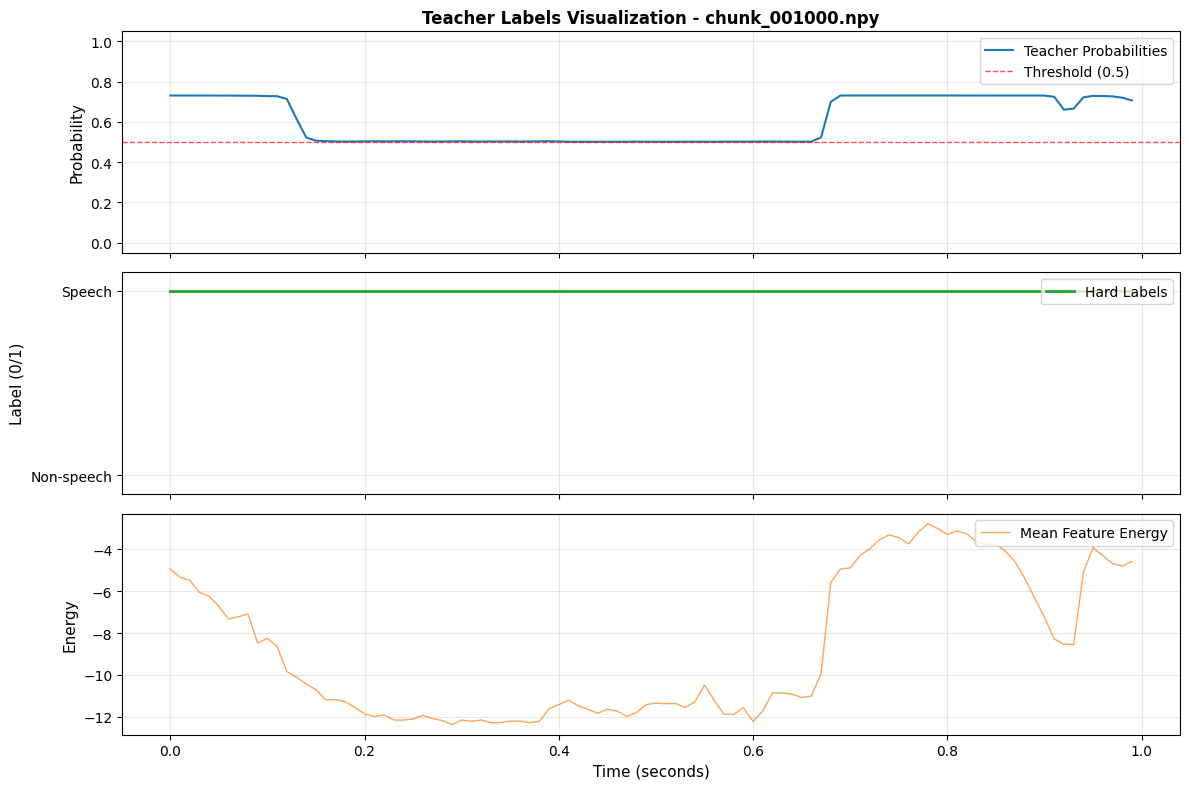


Label Transitions:
  Speech segments (0->1): 0
  Silence segments (1->0): 0
  Total transitions: 0


In [35]:
import matplotlib.pyplot as plt
import random

# Randomly select a chunk for visualization
chunk_files = sorted(list(TRAINING_CHUNKS_DIR.glob("chunk_*.npy")))
if not chunk_files:
    print("No chunk files found for visualization")
else:
    # Randomly select one chunk
    selected_chunk_path = chunk_files[1000]
    print(f"Selected chunk: {selected_chunk_path.name}")
    
    # Load chunk data
    chunk_data = np.load(selected_chunk_path, allow_pickle=True).item()
    
    features = chunk_data["features"]
    teacher_probs = chunk_data["teacher_probs"]
    hard_labels = chunk_data["hard_labels"]
    
    print(f"\nChunk Information:")
    print(f"  File ID: {chunk_data.get('uid', 'N/A')}")
    print(f"  Chunk ID: {chunk_data.get('chunk_id', 'N/A')}")
    print(f"  Features shape: {features.shape}")
    print(f"  Teacher probs shape: {teacher_probs.shape}")
    print(f"  Hard labels shape: {hard_labels.shape}")
    print(f"  Duration: {CHUNK_DURATION}s")
    
    print(f"\nTeacher Probabilities Statistics:")
    print(f"  Min: {teacher_probs.min():.4f}")
    print(f"  Max: {teacher_probs.max():.4f}")
    print(f"  Mean: {teacher_probs.mean():.4f}")
    print(f"  Std: {teacher_probs.std():.4f}")
    print(f"  Values > 0.5: {np.sum(teacher_probs > 0.5)} / {len(teacher_probs)} ({100 * np.sum(teacher_probs > 0.5) / len(teacher_probs):.1f}%)")
    
    print(f"\nHard Labels Statistics:")
    print(f"  Speech frames (1): {np.sum(hard_labels == 1)} / {len(hard_labels)} ({100 * np.sum(hard_labels == 1) / len(hard_labels):.1f}%)")
    print(f"  Non-speech frames (0): {np.sum(hard_labels == 0)} / {len(hard_labels)} ({100 * np.sum(hard_labels == 0) / len(hard_labels):.1f}%)")
    
    # Create visualization
    time_axis = np.arange(len(teacher_probs)) * FRAME_HOP
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    
    # Plot 1: Teacher probabilities
    axes[0].plot(time_axis, teacher_probs, color="tab:blue", linewidth=1.5, label="Teacher Probabilities")
    axes[0].axhline(y=0.5, color="red", linestyle="--", linewidth=1, alpha=0.7, label="Threshold (0.5)")
    axes[0].set_ylabel("Probability", fontsize=11)
    axes[0].set_title(f"Teacher Labels Visualization - {selected_chunk_path.name}", fontsize=12, fontweight="bold")
    axes[0].set_ylim(-0.05, 1.05)
    axes[0].grid(alpha=0.3)
    axes[0].legend(loc="upper right")
    
    # Plot 2: Hard labels
    axes[1].plot(time_axis, hard_labels, color="tab:green", linewidth=2, label="Hard Labels", drawstyle="steps-post")
    axes[1].set_ylabel("Label (0/1)", fontsize=11)
    axes[1].set_ylim(-0.1, 1.1)
    axes[1].grid(alpha=0.3)
    axes[1].legend(loc="upper right")
    axes[1].set_yticks([0, 1])
    axes[1].set_yticklabels(["Non-speech", "Speech"])
    
    # Plot 3: Feature energy (mean across mel bins) for context
    feature_energy = np.mean(features, axis=1)
    axes[2].plot(time_axis, feature_energy, color="tab:orange", linewidth=1, label="Mean Feature Energy", alpha=0.7)
    axes[2].set_xlabel("Time (seconds)", fontsize=11)
    axes[2].set_ylabel("Energy", fontsize=11)
    axes[2].grid(alpha=0.3)
    axes[2].legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()
    
    # Print transition information
    transitions = np.diff(hard_labels)
    num_speech_segments = np.sum(transitions == 1)  # 0 -> 1 transitions
    num_silence_segments = np.sum(transitions == -1)  # 1 -> 0 transitions
    
    print(f"\nLabel Transitions:")
    print(f"  Speech segments (0->1): {num_speech_segments}")
    print(f"  Silence segments (1->0): {num_silence_segments}")
    print(f"  Total transitions: {num_speech_segments + num_silence_segments}")

